In [894]:
from flowermd.base import Molecule
from flowermd.base import Pack
#from flowermd.library import Graphene
import math
import numpy as np
from flowermd.library import KremerGrestBeadSpring, LJChain
from cmeutils.visualize import FresnelGSD

In [895]:
import mbuild as mb
from mbuild.compound import Compound
from mbuild.lattice import Lattice

from flowermd.base import Molecule, System


class Graphene(System):
    def __init__(
        self,
        x_repeat,
        y_repeat,
        n_layers,
        base_units=dict(),
        periodicity=(True, True, False),
    ):
        surface = mb.Compound(periodicity=periodicity)
        scale = 0.246 # 1.0 for testing, 0.246 for graphene bond lengths
        spacings = [s * scale for s in [1.0, 1.0, 1.0]]
        points = [[0, 0, 0], [2/3, 1/3, 0]]
        lattice = Lattice(
            lattice_spacing=spacings,
            angles=[90, 90, 120],
            lattice_points={"A": points},
        )
        carbon = Compound(name="C", element="C")
        layers = lattice.populate(
            compound_dict={"A": carbon}, x=x_repeat, y=y_repeat, z=n_layers
        )
        surface.add(layers)
        surface.freud_generate_bonds("C", "C", dmin=0.3*scale, dmax=0.6*scale)
        surface_mol = Molecule(num_mols=1, compound=surface)
        super(Graphene, self).__init__(
            molecules=[surface_mol],
            base_units=base_units,
        )

    def _build_system(self):
        return self.all_molecules[0]

In [896]:
sheet = Graphene(x_repeat=5, y_repeat=5, n_layers=1, periodicity=(False, False, False))

In [897]:
system = Pack(molecules= Molecule(compound=sheet.all_molecules[0], num_mols=5), density = 0.2)
system.hoomd_snapshot.configuration.box = [15, 15, 15, 0, 0, 0]

/home/eridanirojas/miniconda3/envs/flowermd/lib/python3.12/site-packages/mbuild/compound.py:547: UserWarning: Some particle of <Compound 50 particles, 61 bonds, System box: Box: Lx=1.230000, Ly=1.230000, Lz=0.246000, xy=-0.577350, xz=0.000000, yz=-0.577350, , id: 139951735541104> does not have a charge.They will not be accounted for during this calculation.
  warn(
/home/eridanirojas/miniconda3/envs/flowermd/lib/python3.12/site-packages/mbuild/compound.py:547: UserWarning: Some particle of <Compound 50 particles, 61 bonds, System box: Box: Lx=1.230000, Ly=1.230000, Lz=0.246000, xy=-0.577350, xz=0.000000, yz=-0.577350, , id: 139954401842800> does not have a charge.They will not be accounted for during this calculation.
  warn(
/home/eridanirojas/miniconda3/envs/flowermd/lib/python3.12/site-packages/mbuild/compound.py:547: UserWarning: Some particle of <Compound 50 particles, 61 bonds, System box: Box: Lx=1.230000, Ly=1.230000, Lz=0.246000, xy=-0.577350, xz=0.000000, yz=-0.577350, , id: 

In [837]:
system.visualize()

/home/eridanirojas/miniconda3/envs/flowermd/lib/python3.12/site-packages/mbuild/compound.py:547: UserWarning: Some particle of <Compound 250 particles, 305 bonds, System box: Box: Lx=14.606609, Ly=14.606609, Lz=14.606609, xy=0.000000, xz=0.000000, yz=0.000000, , id: 139951740442656> does not have a charge.They will not be accounted for during this calculation.
  warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [838]:
positions = system.hoomd_snapshot.particles.position

# Example: distance between particle 0 and 1
d = np.linalg.norm(positions[0] - positions[1])
print(f"Distance between particle 0 and 1: {d:.5f} nm")

Distance between particle 0 and 1: 0.24596 dimensionless nm


In [839]:
print(system.hoomd_snapshot.particles.position[0])
print(system.hoomd_snapshot.particles.position[1])
print(system.hoomd_snapshot.particles.position[2])
print(system.hoomd_snapshot.particles.position[3])

[-7.0882696 -4.752661   5.3170747] dimensionless
[-6.9804935 -4.6572417  5.1176318] dimensionless
[-6.8726408 -4.5617739  4.9181467] dimensionless
[-6.7648647 -4.4663547  4.7187038] dimensionless


In [840]:
np.linalg.norm(np.array(system.hoomd_snapshot.particles.position[0]) - np.array(system.hoomd_snapshot.particles.position[1]))

0.24596341375113184

In [841]:
np.linalg.norm(np.array(system.hoomd_snapshot.particles.position[2]) - np.array(system.hoomd_snapshot.particles.position[1]))

0.2460500169805729

In [842]:
np.linalg.norm(np.array(system.hoomd_snapshot.particles.position[3]) - np.array(system.hoomd_snapshot.particles.position[2]))

0.2459633749570446

In [843]:
np.linalg.norm(np.array(system.hoomd_snapshot.particles.position[3]) - np.array(system.hoomd_snapshot.particles.position[0]))

0.737976802298359

In [844]:
sheet.all_molecules[0]

<Compound 50 particles, 61 bonds, System box: Box: Lx=1.230000, Ly=1.230000, Lz=0.246000, xy=-0.577350, xz=0.000000, yz=-0.577350, , id: 139951740416896>

In [845]:

system.n_molecules

5

In [846]:
system.n_particles

250

In [847]:
snap = system.hoomd_snapshot
print(snap.particles.types)
print(snap.bonds.types)
print(snap.angles.types)
print(snap.dihedrals.types)

['C']
['C-C']
['C-C-C']
['C-C-C-C']


In [848]:
from flowermd.library.forcefields import BeadSpring

In [849]:
s = 0.246 # 1.0 for scaling

In [883]:
ff = BeadSpring(
    r_cut=2.5,
    beads={"C": dict(epsilon=0.1, sigma=1.0)},
    bonds={"C-C": dict(r0=0.57736*s, k=500)},
    angles={"C-C-C": dict(t0=2*np.pi/3, k=500)},
    dihedrals={"C-C-C-C": dict(phi0=0.1, k=500, d=1, n=1)}
)

In [884]:
print(len(system.hoomd_snapshot.dihedrals.types))
print(len(system.hoomd_snapshot.dihedrals.group))

1
880


In [885]:
from flowermd.base import Pack, Simulation
import hoomd
import gsd.hoomd

In [886]:
del sim

In [887]:
cpu = hoomd.device.CPU()

In [888]:
sim = Simulation(initial_state=system.hoomd_snapshot, forcefield=ff.hoomd_forces, device = cpu,
                 gsd_write_freq=int(1000), gsd_file_name="single_sheet.gsd")

Initializing simulation state from a gsd.hoomd.Frame.


In [889]:
for force in sim.forces:
    print(force)

In [890]:
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)

In [891]:
from flowermd.utils import get_target_box_number_density
import unyt as u

In [892]:
sim.run_NVT(n_steps=2e5,kT=1.0, tau_kt = 0.1) #short for initial testing
sim.flush_writers()

Step 1000 of 200000; TPS: 3792.81; ETA: 0.9 minutes
Step 2000 of 200000; TPS: 5468.96; ETA: 0.6 minutes
Step 3000 of 200000; TPS: 6414.49; ETA: 0.5 minutes
Step 4000 of 200000; TPS: 7055.58; ETA: 0.5 minutes
Step 5000 of 200000; TPS: 7478.28; ETA: 0.4 minutes
Step 6000 of 200000; TPS: 7762.44; ETA: 0.4 minutes
Step 7000 of 200000; TPS: 7995.65; ETA: 0.4 minutes
Step 8000 of 200000; TPS: 8168.31; ETA: 0.4 minutes
Step 9000 of 200000; TPS: 8325.55; ETA: 0.4 minutes
Step 10000 of 200000; TPS: 8458.3; ETA: 0.4 minutes
Step 11000 of 200000; TPS: 8516.07; ETA: 0.4 minutes
Step 12000 of 200000; TPS: 8593.26; ETA: 0.4 minutes
Step 13000 of 200000; TPS: 8654.11; ETA: 0.4 minutes
Step 14000 of 200000; TPS: 8728.93; ETA: 0.4 minutes
Step 15000 of 200000; TPS: 8791.55; ETA: 0.4 minutes
Step 16000 of 200000; TPS: 8836.14; ETA: 0.3 minutes
Step 17000 of 200000; TPS: 8878.83; ETA: 0.3 minutes
Step 18000 of 200000; TPS: 8908.84; ETA: 0.3 minutes
Step 19000 of 200000; TPS: 8943.65; ETA: 0.3 minutes
Ste

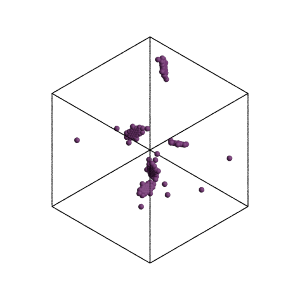

In [893]:
sim_visualizer = FresnelGSD(gsd_file="single_sheet.gsd", frame=1, view_axis=(1, 1, 1))
sim_visualizer.view()